# Predicting wind turbine power output
By Unai Barredo ([GitHub](https://github.com/ubarredo/NEM-DataChallenge)) 

## Imports

For this task we need to import some necessary libraries and functions.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

sns.set(context ='notebook', style='darkgrid', color_codes=True)
%matplotlib inline

## Historical Dataset

First we will load the processed historical data into a dataframe. We only need the WNACWindSpeed, WNACAmbTemp, WTURPower and asset features as they are the only ones in our evaluation dataset.

In [2]:
historical = pd.DataFrame()
for dataset in os.listdir('processed/'):
    if '.csv.gz' in dataset:
        processed = pd.read_csv('processed/' + dataset,
                                usecols=['asset', 'WNACWindSpeed', 'WNACAmbTemp', 'WTURPower'],
                                compression='gzip')
        historical = historical.append(processed)
historical.info()
historical.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108868 entries, 0 to 22141
Data columns (total 4 columns):
asset            108868 non-null object
WNACAmbTemp      108868 non-null float64
WNACWindSpeed    108867 non-null float64
WTURPower        108867 non-null float64
dtypes: float64(3), object(1)
memory usage: 4.2+ MB


,asset,WNACAmbTemp,WNACWindSpeed,WTURPower
34,A001,0.31047,0.18429,0.25388
952,A001,0.39746,0.20029,0.29897
17261,A004,0.23416,0.16886,0.16150
13165,A004,0.72691,0.08057,0.00372
18496,A005,0.37545,0.15971,0.15843


## Data Processing

* Deal with the numeric missing values (NaN's). Since there is only one we will just drop it.
* Create Dummy variables for the asset categorical feature.
* Transform the numerical values by taking log (10*value + 1), this will make the features more normal.

In [3]:
historical.dropna(inplace=True)
historical = pd.get_dummies(historical)
historical.info()
historical.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108867 entries, 0 to 22141
Data columns (total 8 columns):
WNACAmbTemp      108867 non-null float64
WNACWindSpeed    108867 non-null float64
WTURPower        108867 non-null float64
asset_A001       108867 non-null uint8
asset_A002       108867 non-null uint8
asset_A003       108867 non-null uint8
asset_A004       108867 non-null uint8
asset_A005       108867 non-null uint8
dtypes: float64(3), uint8(5)
memory usage: 3.8 MB


,WNACAmbTemp,WNACWindSpeed,WTURPower,asset_A001,asset_A002,asset_A003,asset_A004,asset_A005
16552,0.27742,0.11171,0.03500,0,0,0,1,0
8908,0.63545,0.14286,0.08155,0,0,1,0,0
19758,0.29441,0.25629,0.65973,0,0,0,0,1
740,0.56414,0.05914,-0.00327,1,0,0,0,0
11206,0.64992,0.15857,0.11980,0,0,1,0,0


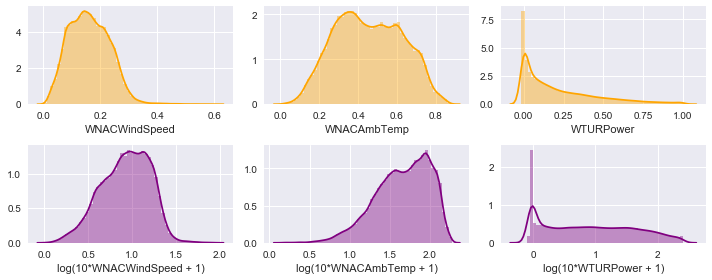

In [4]:
f, axes = plt.subplots(2, 3, figsize=(10, 4))
n = 0
for feature in ['WNACWindSpeed', 'WNACAmbTemp', 'WTURPower']:
    sns.distplot(historical[feature],
                 ax=axes.flat[n], color='orange')
    sns.distplot(np.log1p(10 * historical[feature]),
                 ax=axes.flat[n + 3], color='purple')
    axes.flat[n].set_xlabel(feature)
    axes.flat[n + 3].set_xlabel(f'log(10*{feature} + 1)')
    n += 1
f.tight_layout()

In [5]:
log_historical = np.log1p(10 * historical)

## Modelling

We are going to try different approaches to create the model, and check the error metrics.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(log_historical.drop('WTURPower', axis=1),
                                                    log_historical['WTURPower'])
models = {'Linear': LinearRegression(),
          'Ridge': RidgeCV(),
          'Lasso': LassoCV(),
          'SuportVector': SVR(max_iter=1000),
          'RandomForest': RandomForestRegressor(),
          'GradientBoosting': GradientBoostingRegressor()}
original = .1 * np.expm1(y_test)
metrics = pd.DataFrame()
for m in models:
    models[m].fit(x_train, y_train)
    predicted = .1 * np.expm1(models[m].predict(x_test))
    metrics.loc[m, 'explained_variance'] = explained_variance_score(original, predicted)
    metrics.loc[m, 'mean_abs_error'] = mean_absolute_error(original, predicted)
    metrics.loc[m, 'mean_sq_error'] = mean_squared_error(original, predicted)
    metrics.loc[m, 'median_abs_error'] = median_absolute_error(original, predicted)
    metrics.loc[m, 'r2_score'] = r2_score(original, predicted)
metrics.round(5)

,explained_variance,mean_abs_error,mean_sq_error,median_abs_error,r2_score
Linear,0.90517,0.04385,0.00560,0.02672,0.90187
Ridge,0.90515,0.04386,0.00560,0.02673,0.90184
Lasso,0.90495,0.04397,0.00561,0.02678,0.90158
SuportVector,0.65128,0.10055,0.02655,0.04935,0.53455
RandomForest,0.98083,0.01781,0.00110,0.00982,0.98080
GradientBoosting,0.98610,0.01557,0.00080,0.00848,0.98605


By far we see that we obtain the best results with the ensemble methods. We are going to use the Gradient Boost method.

In [7]:
gboost = GradientBoostingRegressor()
gboost.fit(x_train, y_train)
predicted = .1 * np.expm1(gboost.predict(x_test))
pd.DataFrame({'original': original, 'predicted': predicted}).round(5).sample(5)

,original,predicted
11161,0.07832,0.08098
11774,0.21119,0.19831
5356,0.30792,0.29931
16181,0.11558,0.11192
9816,0.00068,0.00905


## Evaluation Dataset

We will load each set of forecast data one by one, to have an information with a period of 10 minutes we interpolate the data and fill it. Finally, we will apply our model to create a prediction of energy production and export the results.

In [8]:
for dataset in os.listdir('forecasts/'):
    if '.csv.gz' in dataset:
        forecast = pd.read_csv('forecasts/' + dataset, compression='gzip')
        bot = forecast['unixtime'].min() + 600
        top = (forecast['unixtime'] + forecast['range']).max() + 600
        forecast['unixtime'] = forecast['unixtime'] + forecast['range']
        forecast.drop('range', axis=1, inplace=True)
        times = range(bot, top, 600)
        assets = forecast['asset'].unique()
        evaluation = pd.DataFrame(list(product(assets, times)), columns=['asset', 'unixtime'])
        evaluation = pd.merge(evaluation, forecast, on=['asset', 'unixtime'], how='left')
        evaluation.interpolate(method='linear', inplace=True)
        evaluation.fillna(method='bfill', inplace=True)
        log_evaluation = np.log1p(10 * pd.get_dummies(evaluation.drop('unixtime', axis=1)))
        log_evaluation = log_evaluation[x_train.columns.tolist()]
        evaluation['WTURPower'] = .1 * np.expm1(gboost.predict(log_evaluation))
        evaluation.round(5).to_csv('predictions/' + dataset,
                                   index=False,
                                   columns=['asset', 'unixtime', 'WTURPower'],
                                   compression='gzip')
evaluation.info()
evaluation.round(5).sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5040 entries, 0 to 5039
Data columns (total 5 columns):
asset            5040 non-null object
unixtime         5040 non-null int64
WNACWindSpeed    5040 non-null float64
WNACAmbTemp      5040 non-null float64
WTURPower        5040 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 236.2+ KB


,asset,unixtime,WNACWindSpeed,WNACAmbTemp,WTURPower
4131,A005,1444581600,0.03114,0.34157,-0.00154
322,A001,1444715400,0.26749,0.24115,0.70142
1513,A002,1444825200,0.20286,0.25931,0.30887
1083,A002,1444567200,0.08153,0.42184,-0.00062
3390,A004,1444741800,0.28099,0.35320,0.75235


Visualising our prediction of energy production output for a week, we see that it is directly correlated with the wind speed forecast. 

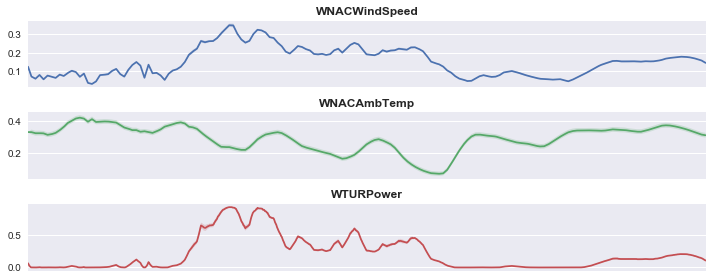

In [9]:
f, axes = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
colors = ['b', 'g', 'r']
n = 0
for feature in ['WNACWindSpeed', 'WNACAmbTemp', 'WTURPower']:
    sns.tsplot(data=evaluation, time='unixtime', value=feature, unit='asset',
               ax=axes[n], color=colors[n])
    axes[n].set_title(feature, fontweight='bold')
    axes[n].set(xticks=(), ylabel='', xlabel='')
    n += 1
f.tight_layout()